In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten
from keras.models import Model
import numpy as np
import pandas as pd
import os
import sys
from keras.optimizers import Adam
import skimage.io
from multiprocessing import Pool
import tensorflow as tf


Using TensorFlow backend.


# Read in Images

In [2]:
# This can be used for CNN
def read_images(dir):
    # rescales images
    datagen = ImageDataGenerator(rescale=1./255)
    
    generator = datagen.flow_from_directory(
        dir,
        target_size = (256, 256),
        batch_size = 64,
        class_mode = 'input', # for autoencoder
        color_mode = 'rgb'
    )
    
    return(generator)

In [3]:
datasets = {
    'train': 'data/training', 
    'test': 'data/testing', 
    'valid': 'data/validation',}

key_to_generator = {k: read_images(v) for k,v in datasets.items()}

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [4]:
epochs = 400 # epochs of training, the more the better
batch_size = 64 # number of images to be yielded from the generator per batch
seed = 4321 # constant seed for constant conditions

train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        'data/training',
        target_size = (256, 256),
        batch_size = batch_size,
        class_mode = 'input',
        color_mode = 'rgb',
        shuffle=True
    )
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        'data/testing',
        target_size = (256, 256),
        batch_size = batch_size,
        class_mode = 'input',
        color_mode = 'rgb',
        shuffle=True
    )

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [5]:
key_to_generator

{'train': <keras.preprocessing.image.DirectoryIterator at 0x1c3c5d2b38>,
 'test': <keras.preprocessing.image.DirectoryIterator at 0x10f9caeb8>,
 'valid': <keras.preprocessing.image.DirectoryIterator at 0x1c3c361b00>}

In [6]:
type(key_to_generator['train'])

keras.preprocessing.image.DirectoryIterator

In [7]:
key_to_generator['train'][0][0].shape

(64, 256, 256, 3)

In [8]:
key_to_generator['train']

In [9]:
key_to_generator['train'][0][0].dtype

dtype('float32')

image dimensions: (256, 256, 3)


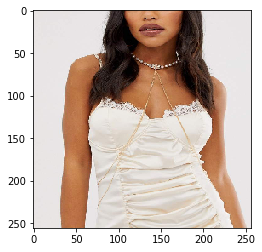

In [10]:
# show an earring
print(f'image dimensions: {key_to_generator["train"][1][0][2].shape}')
plt.imshow(key_to_generator['train'][0][0][0]);

In [11]:
# confirm the iterator works
batchX, batchy = key_to_generator["train"].next()
print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))

Batch shape=(64, 256, 256, 3), min=0.000, max=1.000


In [12]:
# dimensions of our images.
img_width, img_height = 256, 256
img_channel = 3
input_img = Input(shape=(img_width, img_height, img_channel)) #rgb

input_img

<tf.Tensor 'input_1:0' shape=(None, 256, 256, 3) dtype=float32>

In [13]:
import glob
os.getcwd()

'/Users/linhchau/Desktop/galvanize/jewelery_recommender'

In [14]:
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [256, 256])
    image /= 255.0  # normalize to [0,1] range

    return image


In [15]:
def read_imgs_dir(path, extension):
    filelist = glob.glob(f'{path}/*.{extension}')
    imgs = [skimage.io.imread(file, as_gray=False) for file in filelist]
    processed_imgs = [preprocess_image(img) for img in imgs]
    return processed_imgs

In [16]:
# def preprocess_image(image):
# #     image = tf.image.decode_jpeg(image, channels=3)
#     image = tf.image.resize(image, [256,256])
#     image /= 255. # normalize pixels
#     return image

In [71]:
single_test = skimage.io.imread('data/validation/earrings/806404148.jpg', as_gray=False)
single_test.shape
# test_image = tf.image.decode_jpeg(test, channels=3)
single_test = tf.image.resize(single_test, [256,256]) 
single_test/= 255.

<tf.Tensor: id=1177, shape=(256, 256, 3), dtype=float32, numpy=
array([[[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       ...,

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]]], dtype=float32)>

In [18]:
valid = read_imgs_dir('data/validation/earrings/', 'jpg')

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).

In [19]:
train_dir = 'data/validation/earrings/'
def read_imgs_dir(path, extension):
    filelist = glob.glob(f'{path}/*.{extension}')
    return(filelist)
#     list_ds = tf.data.Dataset.list_files(filelist)

files = read_imgs_dir(train_dir, 'jpg')

In [20]:
import cv2
def read_imgs_dir2(path, extension):
    X_data = []
    filelist = glob.glob(f'{path}/*.{extension}')
    for file in filelist:
        img = cv2.imread(file)
        X_data.append(img)
    return X_data

In [21]:
train_dir = 'data/validation/earrings/'
files = read_imgs_dir2(train_dir, 'jpg')

In [22]:
np.array(files).shape

(500,)

In [23]:
X_data = []
files = glob.glob(f'data/validation/earrings/*.jpg')
for myFile in files:
    image = cv2.imread(myFile)
    assert image.shape == (256,256,3), "img %s has shape %r" % (myFile, image.shape)
    X_data.append(image)

print('X_data shape:', np.array(X_data).shape)

AssertionError: img data/validation/earrings/799035376.jpg has shape (364, 242, 3)

In [24]:
type(files)

list

In [25]:
import pathlib
data_dir = pathlib.Path('data/training')
for item in data_dir.glob("*"):
  print(item.name)

.DS_Store
earrings
necklaces


In [26]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

for f in list_ds.take(5):
  print(f.numpy())

AUTOTUNE = tf.data.experimental.AUTOTUNE ## tf.data transformation parameters

# def get_label(file_path):
#   # convert the path to a list of path components
#     parts = tf.strings.split(file_path, '/')
#     print(parts[-2])
# #   # The second to last is the class-directory
# #     return parts[-2] == CLASS_NAMES

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img

list_ds.map(process_path)

# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
# labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

# for image, label in labeled_ds.take(1):
#     print("Image shape: ", image.numpy().shape)
#     print("Label: ", label.numpy())

b'data/training/necklaces/788509632.jpg'
b'data/training/necklaces/797812590.jpg'
b'data/training/earrings/791267432.jpg'
b'data/training/necklaces/768041332.jpg'
b'data/training/earrings/795092468.jpg'


NameError: in converted code:

    <ipython-input-26-8689d13a14b6>:24 process_path  *
        label = get_label(file_path)

    NameError: name 'get_label' is not defined


In [27]:
# Read images with common extensions from a directory
def read_imgs_dir(dirPath, extension):
    filelist = glob.glob(f'{dirPath}/*.{extension}')
    imgs = [skimage.io.imread(file, as_gray=False) for file in filelist]
    return imgs

In [28]:
train = read_imgs_dir('data/training/earrings/', 'jpg')

In [29]:
# train.shape

In [30]:
# np.asarray(train, np.float32)
# data_tf = tf.convert_to_tensor(train, np.float32)

In [61]:
test = read_imgs_dir('data/testing/earrings/', 'jpg')

In [62]:
test

[Array([[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        ...,
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
  

In [32]:
train[0].shape

(65, 497, 3)

In [33]:
def norm_image(img):
    return img/255.

# norm_img(train[0])

In [34]:
from skimage.transform import resize

def resize_image(img, new_size=[256, 256]):
    img_resized = resize(img, new_size,
                        anti_aliasing = True,
                        preserve_range = True)
    img_resized.shape == new_size
    return(img_resized.astype(np.float32))

In [35]:
def apply_transformations(imgs, transformation):
    img_transformed = [transformation(img) for img in imgs]
    return(img_transformed)

In [63]:
train_trans = apply_transformations(train, norm_image)
train_trans = apply_transformations(train_trans, resize_image)

test_trans = apply_transformations(test, norm_image)
test_trans = apply_transformations(test_trans, resize_image)

In [37]:
train_trans[3].shape
# train_trans[0].dtype

(256, 256, 3)

In [64]:
test_trans

[array([[[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],
 
        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],
 
        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],
 
        ...,
 
        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],
 
        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],
 
        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]]], dtype=float32),
 array([[[0.9411765 , 0.92156863, 0.9450

In [38]:
train_trans[0].shape

(256, 256, 3)

In [39]:
train_trans.reshape((256, 256, 3))

AttributeError: 'list' object has no attribute 'reshape'

In [59]:
test_trans

[]

In [40]:
X_train = np.array([x.reshape(256,256,3) for x in train_trans])
X_test = np.array([x.reshape(256,256,3) for x in test_trans])

ValueError: cannot reshape array of size 65536 into shape (256,256,3)

In [41]:
# dimensions of our images.
img_width, img_height = 256, 256
img_channel = 3
shape_img = Input(shape=(img_width, img_height, img_channel))

In [42]:
input_shape_model = tuple([img_width, img_height, img_channel])
input_shape_model

X_train = np.array(train_trans).reshape((-1,) + input_shape_model)
# X_test = np.array(imgs_test_transformed).reshape((-1,) + input_shape_model)

ValueError: could not broadcast input array from shape (256,256,3) into shape (256,256)

In [43]:
train_trans

[array([[[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],
 
        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],
 
        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],
 
        ...,
 
        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],
 
        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],
 
        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]]], dtype=float32),
 array([[[0.33831748, 0.2128273 , 0.1633

In [44]:
input_shape_model

(256, 256, 3)

# Model

In [45]:
n_hidden_1, n_hidden_2, n_hidden_3 = 32, 16, 8
conv_kernel = (3,3)
pool_kernel = (2,2)

input_img = Input(shape=(img_width, img_height, img_channel))
# create convolutional autoencoder inspired from https://blog.keras.io/building-autoencoders-in-keras.html
x = Conv2D(n_hidden_1, conv_kernel, activation='relu', padding='same')(input_img)
x = MaxPooling2D(pool_kernel,padding='same')(x)

x = Conv2D(n_hidden_1, conv_kernel, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_kernel, padding='same')(x)

x = Conv2D(n_hidden_2, conv_kernel, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_kernel, padding='same')(x)

x = Conv2D(n_hidden_3, conv_kernel, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_kernel, padding='same')(x)

x = Conv2D(n_hidden_3, conv_kernel, activation='relu', padding='same')(x)
encoded = MaxPooling2D(pool_kernel, padding='same')(x)


x = Conv2D(n_hidden_3, conv_kernel, activation='relu', padding='same')(encoded)
x = UpSampling2D(pool_kernel)(x)

x = Conv2D(n_hidden_3, conv_kernel, activation='relu', padding='same')(x)
x = UpSampling2D(pool_kernel)(x)

x = Conv2D(n_hidden_2, conv_kernel, activation='relu', padding='same')(x)
x = UpSampling2D(pool_kernel)(x)

x = Conv2D(n_hidden_1, conv_kernel, activation='relu', padding='same')(input_img)
x = UpSampling2D(pool_kernel)(x)

x = Conv2D(n_hidden_1, conv_kernel, activation='relu', padding='same')(input_img)
x = UpSampling2D(pool_kernel)(x)

decoded = Conv2D(img_channel, pool_kernel, activation='sigmoid', padding='same')(x)


In [46]:
autoencoder = Model(input_img, decoded)
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 256, 256, 32)      896       
_________________________________________________________________
up_sampling2d_5 (UpSampling2 (None, 512, 512, 32)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 512, 512, 3)       387       
Total params: 1,283
Trainable params: 1,283
Non-trainable params: 0
_________________________________________________________________


In [47]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [75]:
autoencoder_train = autoencoder.fit(
    np.array(single_test).reshape((1, 256, 256, 3)), 
    steps_per_epoch = 1, 
    validation_data = np.array(single_test).reshape((1, 256, 256, 3))
)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [77]:
np.array(single_test).shape

(256, 256, 3)

In [79]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

# x_train = x_train.astype('float32') / 255.
# x_test = x_test.astype('float32') / 255.
# x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
# x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

In [82]:
x_train.shape

(60000, 28, 28)

In [83]:
single_test.shape

TensorShape([256, 256, 3])

In [86]:
import os
import skimage.io
from multiprocessing import Pool
import os
import numpy as np
import tensorflow as tf
from sklearn.neighbors import NearestNeighbors

# Read image
def read_img(filePath):
    return skimage.io.imread(filePath, as_gray=False)

# Read images with common extensions from a directory
def read_imgs_dir(dirPath, extensions, parallel=True):
    args = [os.path.join(dirPath, filename)
            for filename in os.listdir(dirPath)
            if any(filename.lower().endswith(ext) for ext in extensions)]
    if parallel:
        pool = Pool()
        imgs = pool.map(read_img, args)
        pool.close()
        pool.join()
    else:
        imgs = [read_img(arg) for arg in args]
    return imgs

# Save image to file
def save_img(filePath, img):
    skimage.io.imsave(filePath, img)

In [88]:
dataTrainDir = 'data/training/earrings'

# Read images
extensions = [".jpg", ".jpeg"]
print("Reading train images from '{}'...".format(dataTrainDir))
imgs_train = read_imgs_dir(dataTrainDir, extensions)

Reading train images from 'data/training/earrings'...


In [89]:
imgs_train

[Array([[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        ...,
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
  

In [90]:
class ImageTransformer(object):

    def __init__(self, shape_resize):
        self.shape_resize = shape_resize

    def __call__(self, img):
        img_transformed = resize_img(img, self.shape_resize)
        img_transformed = normalize_img(img_transformed)
        return img_transformed

In [91]:
shape_img_resize = tuple([int(x) for x in model.input.shape[1:]])
transformer = ImageTransformer(shape_img_resize)

NameError: name 'shape_img_resize' is not defined